<center><img src="https://coursereport-s3-production.global.ssl.fastly.net/uploads/school/logo/877/original/applied-20course-20logo.png" width="240" height="220" /></center>

# <center>**HealthCare Fraud Detection Analysis**</center>

---
# **1. Introduction**
---
- Health Insurance Fraud is one of the biggest problems facing Medicare. In this type of fraud, false or misleading information is provided to a health insurance company or the government in an attempt to have them pay unauthorized benefits to the policy holder, another party, or the entity providing services. According to the US government, the total Medicare spending increased exponentially due to frauds in Medicare claims. Healthcare fraud is an organized crime which involves peers of providers, physicians, beneficiaries acting together to make fraud claims. In this crime the providers adopt ways in which an ambiguous diagnosis code is used to adopt costliest procedures and drugs. Insurance companies are the most vulnerable institutions impacted due to these bad practices. Due to this reason, insurance companies increased their insurance premiums and as a result healthcare is becoming a costly matter day by day. Healthcare fraud and abuse take many forms. Some of the most common types of frauds by providers are:

<center><img src="https://nycdsa-blog-files.s3.us-east-2.amazonaws.com/2021/07/emily-wang/cost-of-health-coverage-888552-eiAxdtdO.jpg" height= 450 width= 600 ></center>

- Billing for services that were not provided
- Duplicate submission of a claim for the same service
- Misrepresenting the service provided
- Charging for a more complex or expensive service than was    actually provided
- Billing for a covered service when the service actually provided was not covered





---
# **2. Business Problem**
---
- Identify potentially fraudulent healthcare providers based on the claims filed by them. This will help prevent huge losses incurred by health insurance companies or the government by identifying health care providers who make fraud claims on behalf of their beneficiaries and help them to disburse insurance money to beneficiaries who truly deserve it. This will also help in bringing down the premium costs for insurance and thereby making healthcare more affordable. We are tasked with predicting whether a provider is fraud or not based on the claims filed by them and discover important variables helpful in detecting the behaviour of potentially fraud providers.

## 2.1 Machine Learning Problem
 - This is a binary classification problem, given the inpatient claims, outpatient claims and beneficiary details of a provider we have to predict whether the provider is a fraud or not.

## 2.2 Business Constraint
- The cost of mis-classification can be very high
- No strict latency concerns
- Model interpretability is important. A probability of the provider being a fraud can be provided to make a more informed decision

## 2.3 Metric
- Recall
- F1 score
- AUC score
- Confusion Matrix

---
# **3. Importing libraries**
---

In [ ]:
#-------------------------------------------------------------------------------------------------------------------------------
import pandas as pd                                                 # Importing for panel data analysis
pd.set_option('display.max_columns', None)                          # Unfolding hidden features if the cardinality is high      
pd.set_option('display.max_colwidth', None)                         # Unfolding the max feature width for better clearity      
pd.set_option('display.max_rows', None)                             # Unfolding hidden data points if the cardinality is high
pd.set_option('mode.chained_assignment', None)                      # Removing restriction over chained assignments operations
pd.set_option('display.float_format', lambda x: '%.2f' % x)         # To suppress scientific notation over exponential values
#-------------------------------------------------------------------------------------------------------------------------------
import numpy as np                                                  # Importing package numpys (For Numerical Python)
#-------------------------------------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt                                     # Importing pyplot interface using matplotlib
import seaborn as sns                                               # Importin seaborm library for interactive visualization
%matplotlib inline
#-------------------------------------------------------------------------------------------------------------------------------
import warnings                                                     # Importing warning to disable runtime warnings
warnings.filterwarnings("ignore")                                   # Warnings will appear only once
#-------------------------------------------------------------------------------------------------------------------------------

Utility function

In [ ]:
# https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-bars-in-seaborn
def percentage_with_hue(plot, feature, Number_of_categories, hue_categories, x_pos=0, y_pos=0, fontsize = 12):
    '''
    This function prints percentage of a barplot when plotted with hue.
    '''
    # get the height of each bar
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            # calculate percentage of the category
            percentage = '{:.2f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            # set the x and y position of the percentage value to look good
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 + x_pos
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() + y_pos
            ax.annotate(percentage, (x, y), fontsize = fontsize)
    plt.show()
    
def percentage_without_hue(ax, feature, x_pos=0, y_pos=0, fontsize = 12 ):
    '''
    This function prints percentage of a barplot when plotted without hue.
    '''
    total = len(feature)
    for p in ax.patches:
        # calculate percentage of the category
        percentage = '{:.2f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()/2 + x_pos # To adjust the position of the percentage value
        y = p.get_y() + p.get_height() + y_pos # To adjust the position of the percentage value
        ax.annotate(percentage, (x, y),ha='center', size = fontsize)
    plt.show()

---
# **4. Data Acquisition & Description**
---

- Extracting the zip file

In [ ]:
#unzipping folder
from zipfile import ZipFile
file = '/content/drive/MyDrive/Colab Notebooks/Self_Case_study/1st case study/SelfCaseStudy-1.zip'

with ZipFile(file,'r') as f:
    print('extracting files')
    f.extractall()
    print('Done')

extracting files
Done


Class Labels

In [ ]:
# reading class labels
y_train = pd.read_csv('y_train.csv')
print('Data Shape:', y_train.shape)
y_train.head()

Data Shape: (5410, 2)


,Provider,PotentialFraud
0,PRV51001,No
1,PRV51003,Yes
2,PRV51004,No
3,PRV51005,Yes
4,PRV51007,No


In [ ]:
# no of each class
y_train['PotentialFraud'].value_counts()

No     4904
Yes     506
Name: PotentialFraud, dtype: int64

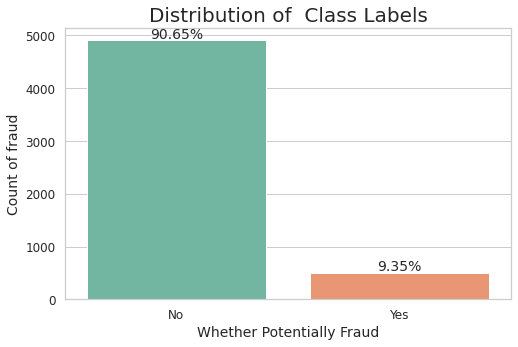

In [ ]:
# countplot for class label
sns.set(style="whitegrid")
plt.figure(figsize=(8,5))
ax=sns.countplot(x ='PotentialFraud', data = y_train, palette = "Set2")
 
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.title('Distribution of  Class Labels', fontsize=20)
plt.xlabel('Whether Potentially Fraud', size = 14)
plt.ylabel('Count of fraud', size = 14)
percentage_without_hue(ax, y_train['PotentialFraud'], 0,40,14)

**Observation:**
- We observe that this is the case high imbalanced dataset.

Training Beneficiary data

In [ ]:
# Reading Beneficiary Details
# data contains beneficiary KYC details like health conditions,region they belong to etc.
train_bene = pd.read_csv('train_Bene.csv')
print('Data Shape:', train_bene.shape)
train_bene.head()

Data Shape: (138556, 25)


,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,2,2,2,2,2,2,2,2,2,2,2,0,0,30,50
2,BENE11003,1936-08-01,NaN,1,1,0,52,590,12,12,1,2,2,2,2,2,2,1,2,2,2,0,0,90,40
3,BENE11004,1922-07-01,NaN,1,1,0,39,270,12,12,1,1,2,2,2,2,1,1,1,1,2,0,0,1810,760
4,BENE11005,1935-09-01,NaN,1,1,0,24,680,12,12,2,2,2,2,1,2,1,2,2,2,2,0,0,1790,1200


####Column details of beneficiary data:

- BeneId: Unique Id for each beneficiary
-DOB: Date of Birth of beneficiary
-DOD: Date of Death of beneficiary
-Gender: Gender of beneficiary
-Race: Race of beneficiary
-RenalDiseaseIndicator: Tells us whether the beneficiary suffers from Renal Disease
-State: State of residence of beneficiary
-County: County where beneficiary resides
-NoOfMonths_PartACov: No. of months Medicare Part A(hospital insurance) is covered where mostly no premium is paid directly by citizens.
-NoOfMonths_PartBCov: No. of months Medicare Part B is covered. Medicare Part B is like a traditional insurance where premium has to be paid monthly to the insurer.
-ChronicCond_Alzheimer: Tells us whether the beneficiary suffers from Alzheimer
-ChronicCond_Heartfailure: Tells us whether beneficiary had a heart failure
-ChronicCond_KidneyDisease: Tells us whether beneficiary suffers from Kidney disease
There are 8 other similar columns which specify whether the beneficiary is suffering from a chronic condition. (Column name format: ChronicCond_DiseaseName)
-IPAnnualReimbursementAmt: Inpatient annual reimbursement of the beneficiary
-IPAnnualDeductibleAmt: Inpatient annual deductible paid by the beneficiary
-OPAnnaulReimbursementAmt: Outpatient annual reimbursement of the beneficiary
-OPAnnualDeductibleAmt: Outpatient annual deductible paid by the beneficiary

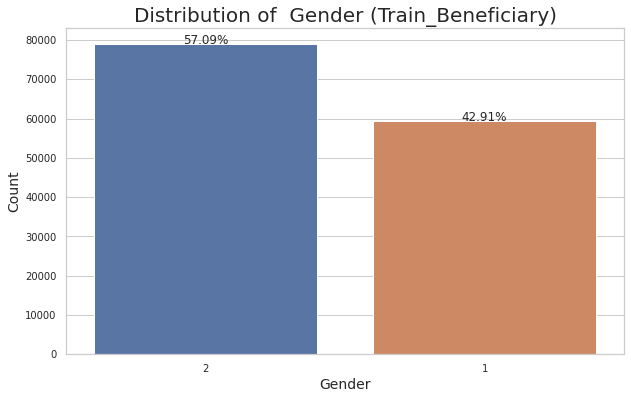

In [ ]:
# Plot distribution of gender in Beneficiaries data
plt.figure(figsize=(10,6))
ax = sns.countplot(x='Gender',data=train_bene, order = train_bene['Gender'].value_counts().index)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.title('Distribution of  Gender (Train_Beneficiary)', fontsize=20)
plt.xlabel('Gender', size = 14)
plt.ylabel('Count', size = 14)
percentage_without_hue(ax, train_bene['Gender'], 0,1,12)

Observation:
- There is difference in gender ratio 57 : 43.

Test Beneficiary data

In [ ]:
# Reading Beneficiary Details
test_bene = pd.read_csv('test_Bene.csv')
print('Data Shape:', test_bene.shape)
test_bene.head()

Data Shape: (63968, 25)


,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
1,BENE11007,1940-09-01,2009-12-01,1,2,0,45,610,12,12,1,1,2,2,2,2,1,2,1,1,2,0,0,1490,160
2,BENE11010,1936-07-01,NaN,2,1,0,41,30,12,12,2,1,2,1,1,2,1,1,1,2,2,0,0,1170,660
3,BENE11011,1914-03-01,NaN,2,2,0,1,360,12,12,2,1,1,2,2,1,1,2,2,1,1,5000,1068,250,320
4,BENE11014,1938-04-01,NaN,2,1,Y,45,780,12,12,2,1,1,2,1,1,2,1,2,2,2,21260,2136,120,100


In [ ]:
# For RenalDiseaseIndicator replacing 'Y' with 1
train_bene = train_bene.replace({'RenalDiseaseIndicator': 'Y'}, 1)

test_bene = train_bene.replace({'RenalDiseaseIndicator': 'Y'}, 1)

Train Inpatient Data

In [ ]:
# This data provides insights about the claims filed for those patients who are admitted in the hospitals
train_inpatient = pd.read_csv('train_In.csv')
print(train_inpatient.shape)
train_inpatient.head()

(40474, 30)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.00,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6186,1068.00,2009-09-02,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.00,NaN,NaN,NaN,NaN,NaN
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,29590,1068.00,2009-09-20,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,431,1068.00,2009-02-22,067,43491,2762,7843,32723,V1041,4254,25062,40390,4019,NaN,331.00,NaN,NaN,NaN,NaN,NaN
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,78321,1068.00,2009-08-30,975,042,3051,34400,5856,42732,486,5119,29620,20300,NaN,3893.00,NaN,NaN,NaN,NaN,NaN


In [ ]:
# this feature will be used as featured engineered column
train_inpatient['is_inpatient'] = 1 # we are adding column which tells us that these patient are admitted in the hospitals

In [ ]:
train_inpatient.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,is_inpatient
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.00,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6186,1068.00,2009-09-02,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.00,NaN,NaN,NaN,NaN,NaN,1
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,29590,1068.00,2009-09-20,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,431,1068.00,2009-02-22,067,43491,2762,7843,32723,V1041,4254,25062,40390,4019,NaN,331.00,NaN,NaN,NaN,NaN,NaN,1
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,78321,1068.00,2009-08-30,975,042,3051,34400,5856,42732,486,5119,29620,20300,NaN,3893.00,NaN,NaN,NaN,NaN,NaN,1


####Column details of Inpatient data:

- BeneId: Id of the beneficiary on behalf of whom the claim was made.
- ClaimId: Unique Id for a claim made by the beneficiary
-ClaimStartDt: Start Date for claim period
-ClaimEndDt: End Date for claim period
-Provider: Id of the provider who made the bills with diagnosis codes and procedure codes
-InscClaimAmtReimbursed: The amount reimbursed by the insurer on the claim made by the beneficiary.
-AttendingPhysician: Id of physician attending the beneficiary during stay in hospital
-OperatingPhysician: Id of physician operating on the beneficiary
-OtherPhysician: Assistant physician ID
-AdmissionDt: Date when the beneficiary was admitted into hospital
-ClmAdmitDiagnosisCode: Diagnosis Code to describe individual’s disease or medical condition at the time of admission of beneficiary
-DeductibleAmtPaid: Deductible paid by the beneficiary. Deductible is the amount that a policyholder has to pay before the insurance company starts paying up.
-DischargeDt: Date when the beneficiary was discharged from hospital
-DiagnosisGroupCode: Specifies Diagnosis-Related Group(DRG). Diagnosis-related group (DRG) is a system which classifies hospital cases according to certain groups,also referred to as DRGs, which are expected to have similar hospital resource use (cost). Based on this insurance companies reimburse hospital costs to the beneficiaries.
- Columns ClaimDiagnosisCode_1 to ClaimDiagnosisCode_10 specify diagnosis codes. Providers that bill Medicare use codes for patient diagnoses and codes for care, equipment, and medications provided.
- Columns ClmProcedureCode_1 to ClmProcedureCode_6 specify procedure codes. “Procedure” code is a catch-all term for codes used to identify what was done to or given to a patient (surgeries, durable medical equipment, medications, etc.).

In [ ]:
test_inpatient = pd.read_csv('test_In.csv')
print(test_inpatient.shape)
test_inpatient.head()

(9551, 30)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11014,CLM67387,2009-09-09,2009-09-16,PRV57070,9000,PHY317786,PHY427017,NaN,2009-09-09,5789,1068.00,2009-09-16,332,5780,5533,496,V420,40390,2851,5990,570,41071,4280,4443.00,5849.00,NaN,NaN,NaN,NaN
1,BENE11017,CLM31237,2008-12-25,2009-01-08,PRV54750,14000,PHY314656,PHY426644,NaN,2008-12-25,5939,1068.00,2009-01-08,661,1889,41071,5990,5601,4588,5845,4549,29570,34831,NaN,5551.00,NaN,NaN,NaN,NaN,NaN
2,BENE11026,CLM78930,2009-12-09,2009-12-13,PRV53758,2000,PHY349495,NaN,NaN,2009-12-09,4019,1068.00,2009-12-13,241,4010,78791,60000,41401,V1254,4372,78650,7813,4254,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BENE11031,CLM56810,2009-06-23,2009-07-06,PRV55825,16000,PHY429538,PHY371893,NaN,2009-06-23,8208,1068.00,2009-07-06,564,8208,4168,920,5990,40391,2859,4254,41400,5849,41401,8152.00,3320.00,NaN,NaN,NaN,NaN
4,BENE11085,CLM34625,2009-01-20,2009-01-31,PRV52338,19000,PHY397161,NaN,NaN,2009-01-20,4279,1068.00,2009-01-31,880,29654,V142,78702,30503,V140,V4582,V6109,7242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#this feature will be used as featured engineered column
test_inpatient['is_inpatient'] = 1 # we are adding column which tells us that these patient are admitted in the hospitals

Train Outpatient Data


In [ ]:
# This data provides insights about the claims details for the patients who were not admitted into the hospital, who only visited there. 
train_out = pd.read_csv('train_Out.csv')
print(train_out.shape)
train_out.head()

(517737, 27)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,V5866,V1272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,30000,72887,4280,7197,V4577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,71947


The above columns explained here:

- BeneID: It contains the unique id of each beneficiary i.e patients.
- ClaimID: It contains the unique id of the claim submitted by the provider.
- ClaimStartDt: It contains the date when the claim started in yyyy-mm-dd format.
- ClaimEndDt: It contains the date when the claim ended in yyyy-mm-dd format.
- Provider: It contains the unique id of the provider.
- InscClaimAmtReimbursed: It contains the amount reimbursed for that particular claim.
- AttendingPhysician: It contains the id of the Physician who attended the patient.
- OperatingPhysician: It contains the id of the Physician who operated on the patient.
- OtherPhysician: It contains the id of the Physician other than AttendingPhysician and OperatingPhysician who treated the patient.
- ClmDiagnosisCode: It contains codes of the diagnosis performed by the provider on the patient for that claim.
- ClmProcedureCode: It contains the codes of the procedures of the patient for treatment for that particular claim.
- DeductibleAmtPaid: It consists of the amount by the patient. That is equal to Total_claim_amount — Reimbursed_amount.

In [ ]:
test_out = pd.read_csv('test_Out.csv')
print(test_out.shape)
test_out.head()

(125841, 27)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11001,CLM392397,2009-06-02,2009-06-02,PRV55962,30,PHY347633,NaN,PHY347633,V5832,V5861,2724,3182,V5869,42731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
1,BENE11001,CLM430760,2009-06-23,2009-06-23,PRV56112,30,PHY381777,NaN,PHY381777,9594,E9174,4019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2,BENE11007,CLM233081,2009-03-07,2009-03-07,PRV56979,200,PHY425311,NaN,PHY425311,7248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,BENE11007,CLM496381,2009-07-29,2009-07-29,PRV56573,10,PHY393253,PHY347995,NaN,58889,2449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5939
4,BENE11007,CLM521391,2009-08-12,2009-08-12,PRV56573,10,PHY417685,NaN,PHY382041,V666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


---
# **5. Combining all the dataframes**
---

<center><img src="https://miro.medium.com/max/1298/1*CkUMIPcls459Mq-7dY1Fvw.jpeg" height= 450 width= 600 ></center>

For train data

In [ ]:
# first we are going to combine Inpatient and Outpatient dataframes on common columns
common_cols = [ col for col in train_inpatient.columns if col in train_out.columns]

# outer join
train_in_out = train_out.merge(train_inpatient, on=common_cols, how='outer')

# inner join of train_in_out and Beneficiary 
train_in_out_bene = train_bene.merge(train_in_out, on='BeneID')

# adding class labels to final datafrmae
combined_train_data = y_train.merge(train_in_out_bene, on='Provider')

For test data

In [ ]:
y_test = pd.read_csv('y_test.csv')
# first we are going to combine Inpatient and Outpatient dataframes on common columns
common_cols = [ col for col in test_inpatient.columns if col in test_out.columns]

# outer join
test_in_out = test_out.merge(test_inpatient, on=common_cols, how='outer')

# inner join of train_in_out and Beneficiary 
test_in_out_bene = test_bene.merge(test_in_out, on='BeneID')

#  final test datafrmae
combined_test_data = y_test.merge(test_in_out_bene, on='Provider')

In [ ]:
print('The shape of train data is',combined_train_data.shape)
print('The shape of test data is',combined_test_data.shape)


The shape of train data is (558211, 56)
The shape of test data is (115531, 55)


In [ ]:
# no of missing values in traindata
combined_train_data.isnull().sum()

Provider                                0
PotentialFraud                          0
BeneID                                  0
DOB                                     0
DOD                                554080
Gender                                  0
Race                                    0
RenalDiseaseIndicator                   0
State                                   0
County                                  0
NoOfMonths_PartACov                     0
NoOfMonths_PartBCov                     0
ChronicCond_Alzheimer                   0
ChronicCond_Heartfailure                0
ChronicCond_KidneyDisease               0
ChronicCond_Cancer                      0
ChronicCond_ObstrPulmonary              0
ChronicCond_Depression                  0
ChronicCond_Diabetes                    0
ChronicCond_IschemicHeart               0
ChronicCond_Osteoporasis                0
ChronicCond_rheumatoidarthritis         0
ChronicCond_stroke                      0
IPAnnualReimbursementAmt          

**Observation**
- There many missing values after merging datasets.We will handle them in preprocessing.

---
# **6. Data Preprocessing**
---

For train data

In [ ]:
# replacing target variable with 1 and 0
combined_train_data['PotentialFraud']= combined_train_data['PotentialFraud'].replace({"Yes":1,"No":0})

In [ ]:
# replacing gender 1/0 with female/male
combined_train_data['Gender'] = combined_train_data['Gender'].replace({1:"Female", 2: "Male"})

In [ ]:
# changing data type of ClaimStartDt and ClainEndDt to datetime
combined_train_data['ClaimStartDt'] = pd.to_datetime(combined_train_data['ClaimStartDt'])
combined_train_data['ClaimEndDt'] = pd.to_datetime(combined_train_data['ClaimEndDt'])

In [ ]:
# changing data type of AdmissionDt and DischargeDt to datetime
combined_train_data['AdmissionDt'] = pd.to_datetime(combined_train_data['AdmissionDt'])
combined_train_data['DischargeDt'] = pd.to_datetime(combined_train_data['DischargeDt'])

In [ ]:
# changing dates to datetime type
combined_train_data['DOB'] = pd.to_datetime(combined_train_data['DOB'])
combined_train_data['DOD'] = pd.to_datetime(combined_train_data['DOD'])

In [ ]:
# replacing '0' with 0 and 'Y' with 1 in RenalDiseaseIndicator column
combined_train_data.RenalDiseaseIndicator.replace({'0':0, 'Y':1}, inplace=True)

In [ ]:
# replacing 2 with 0 for all chronic conditions for eg: ChronicCond_Alzheimer
combined_train_data.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                           'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2, 
                           'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2, 
                           'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2 }, 0, inplace=True)

In [ ]:
# changing data type of ClaimStartDt and ClainEndDt to datetime
combined_train_data['ClaimStartDt'] = pd.to_datetime(combined_train_data['ClaimStartDt'])
combined_train_data['ClaimEndDt'] = pd.to_datetime(combined_train_data['ClaimEndDt'])

In [ ]:
# changing data type of AdmissionDt and DischargeDt to datetime
combined_train_data['AdmissionDt'] = pd.to_datetime(combined_train_data['AdmissionDt'])
combined_train_data['DischargeDt'] = pd.to_datetime(combined_train_data['DischargeDt'])

In [ ]:
combined_train_data.head(10)

,Provider,PotentialFraud,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,ClaimID,ClaimStartDt,ClaimEndDt,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode,AdmissionDt,DischargeDt,DiagnosisGroupCode,is_inpatient
0,PRV51001,0,BENE11727,1930-05-01,NaT,Female,1,1,1,660,12,12,1,1,1,1,0,0,1,1,0,0,0,0,0,300,110,CLM733300,2009-12-17,2009-12-17,20,PHY383007,NaN,PHY383007,5953,42731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaT,NaT,NaN,NaN
1,PRV51001,0,BENE24646,1943-03-01,NaT,Female,1,0,1,440,12,12,1,0,0,0,0,0,1,1,1,0,1,0,0,720,10,CLM372475,2009-05-22,2009-05-23,700,PHY405682,NaN,PHY402512,78650,51889,V5869,4019,V4581,49320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaT,NaT,NaN,NaN
2,PRV51001,0,BENE31617,1933-08-01,NaT,Male,1,0,1,660,12,12,0,0,1,0,0,0,1,1,0,1,0,0,0,1380,370,CLM748221,2009-12-28,2009-12-28,900,PHY345302,NaN,NaN,V446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,59970,NaT,NaT,NaN,NaN
3,PRV51001,0,BENE32715,1936-03-01,NaT,Female,1,0,1,410,12,12,1,1,1,1,1,1,1,1,0,0,0,2020,1068,6700,2700,CLM272936,2009-03-29,2009-03-30,500,PHY318842,PHY392882,NaN,78964,V442,5589,2720,33829,25002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,78902,NaT,NaT,NaN,NaN
4,PRV51001,0,BENE36012,1940-07-01,NaT,Female,1,0,1,510,12,12,0,1,1,0,0,1,1,1,0,0,1,36000,1068,3520,140,CLM58316,2009-07-04,2009-07-08,36000,PHY340163,NaN,NaN,29650,2971,3051,V1254,07070,28260,7823,49300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1068.00,29623,2009-07-04,2009-07-08,882,1.00
5,PRV51001,0,BENE38773,1938-05-01,NaT,Female,1,0,1,160,12,12,0,0,1,0,0,0,0,0,0,0,0,95000,2136,2270,900,CLM52334,2009-05-23,2009-05-25,12000,PHY346762,NaN,NaN,0388,5849,2841,2762,7140,E9444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1068.00,0389,2009-05-23,2009-05-25,864,1.00
6,PRV51001,0,BENE49220,1919-06-01,NaT,Female,1,0,1,510,12,12,1,1,0,0,0,0,0,1,1,0,0,5000,1068,370,70,CLM452024,2009-07-04,2009-07-04,70,PHY402512,NaN,NaN,78965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,78900,NaT,NaT,NaN,NaN
7,PRV51001,0,BENE56354,1920-06-01,NaT,Male,2,0,1,660,12,12,0,1,1,0,0,0,0,0,1,0,0,0,0,320,80,CLM403535,2009-06-08,2009-06-08,100,PHY350459,NaN,NaN,5168,36250,33819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,78659,NaT,NaT,NaN,NaN
8,PRV51001,0,BENE57060,1952-09-01,NaT,Male,2,1,1,410,12,12,1,1,1,0,1,0,1,1,0,0,0,0,0,630,130,CLM578620,2009-09-14,2009-09-14,300,PHY311126,PHY394703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,56722,NaT,NaT,NaN,NaN
9,PRV51001,0,BENE61975,1911-10-01,NaT,Male,2,1,1,440,12,12,0,1,1,0,1,1,1,1,0,0,0,0,0,1590,1070,CLM260292,2009-03-22,2009-03-22,60,PHY392882,NaN,PHY392882,78901,7873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaT,NaT,NaN,NaN


In [ ]:
combined_train_data.isnull().sum()

Provider                                0
PotentialFraud                          0
BeneID                                  0
DOB                                     0
DOD                                554080
Gender                                  0
Race                                    0
RenalDiseaseIndicator                   0
State                                   0
County                                  0
NoOfMonths_PartACov                     0
NoOfMonths_PartBCov                     0
ChronicCond_Alzheimer                   0
ChronicCond_Heartfailure                0
ChronicCond_KidneyDisease               0
ChronicCond_Cancer                      0
ChronicCond_ObstrPulmonary              0
ChronicCond_Depression                  0
ChronicCond_Diabetes                    0
ChronicCond_IschemicHeart               0
ChronicCond_Osteoporasis                0
ChronicCond_rheumatoidarthritis         0
ChronicCond_stroke                      0
IPAnnualReimbursementAmt          

For test data

In [ ]:
# replacing gender 1/0 with female/male
combined_test_data['Gender'] = combined_test_data['Gender'].replace({1:"Female", 2: "Male"})

In [ ]:
# changing data type of ClaimStartDt and ClainEndDt to datetime
combined_test_data['ClaimStartDt'] = pd.to_datetime(combined_test_data['ClaimStartDt'])
combined_test_data['ClaimEndDt'] = pd.to_datetime(combined_test_data['ClaimEndDt'])

In [ ]:
# changing data type of AdmissionDt and DischargeDt to datetime
combined_test_data['AdmissionDt'] = pd.to_datetime(combined_test_data['AdmissionDt'])
combined_test_data['DischargeDt'] = pd.to_datetime(combined_test_data['DischargeDt'])

In [ ]:
# changing dates to datetime type
combined_test_data['DOB'] = pd.to_datetime(combined_test_data['DOB'])
combined_test_data['DOD'] = pd.to_datetime(combined_test_data['DOD'])

In [ ]:
# replacing '0' with 0 and 'Y' with 1 in RenalDiseaseIndicator column
combined_test_data.RenalDiseaseIndicator.replace({'0':0, 'Y':1}, inplace=True)

In [ ]:
# replacing 2 with 0 for all chronic conditions for eg: ChronicCond_Alzheimer
combined_test_data.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                           'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2, 
                           'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2, 
                           'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2 }, 0, inplace=True)

In [ ]:
# changing data type of ClaimStartDt and ClainEndDt to datetime
combined_test_data['ClaimStartDt'] = pd.to_datetime(combined_test_data['ClaimStartDt'])
combined_test_data['ClaimEndDt'] = pd.to_datetime(combined_test_data['ClaimEndDt'])

In [ ]:
# changing data type of AdmissionDt and DischargeDt to datetime
combined_test_data['AdmissionDt'] = pd.to_datetime(combined_test_data['AdmissionDt'])
combined_test_data['DischargeDt'] = pd.to_datetime(combined_test_data['DischargeDt'])

---
# **7. Feature Engineering**
---

#### Adding **age** as our first Feature engineered column

In [ ]:
# all non-null values in DOD column
dod_year = combined_train_data['DOD'].dt.year
dod_year[pd.notnull(dod_year)].value_counts()

2009.00    4131
Name: DOD, dtype: int64

- Most of the DOD values are null, but the remaining 4131 values are of year 2009.

In [ ]:
#  all non-null values in ClaimStartDt
start_year = combined_train_data['ClaimStartDt'].dt.year
print("Frequency of year from ClaimStartDt column: ")
print(start_year[pd.notnull(start_year)].value_counts())


print()
# all non-null values in ClaimEndDt
end_year = combined_train_data['ClaimEndDt'].dt.year
print("Frequency of year from ClaimEndDt column: ")
print(end_year[pd.notnull(end_year)].value_counts())

Frequency of year from ClaimStartDt column: 
2009    555506
2008      2705
Name: ClaimStartDt, dtype: int64

Frequency of year from ClaimEndDt column: 
2009    558210
2008         1
Name: ClaimEndDt, dtype: int64


- We see most the claims have been made in the year 2009 and also we saw above that DOD non null values are also from year 2009.

In [ ]:
combined_train_data['Age'] = 2009 - combined_train_data['DOB'].dt.year
combined_train_data['Age'].head()

0    79
1    66
2    76
3    73
4    69
Name: Age, dtype: int64

In [ ]:
# for test data
combined_test_data['Age'] = 2009 - combined_test_data['DOB'].dt.year

#### Adding **no_of_days_admitted** as our 2nd feature engineered column in our data.

In [ ]:
# we are subtracting Discharge date with Admission date and as well as filling nll values with 0 days
combined_train_data['Days_Admitted'] = (combined_train_data['DischargeDt'] - combined_train_data['AdmissionDt']).fillna(pd.Timedelta('0 days'))
# since now it is in string format , we extracting days from the string
combined_train_data['Days_Admitted'] = combined_train_data['Days_Admitted'].apply(lambda x: int(str(x).split()[0]))

In [ ]:
# for test data
# we are subtracting Discharge date with Admission date and as well as filling nll values with 0 days
combined_test_data['Days_Admitted'] = (combined_test_data['DischargeDt'] - combined_test_data['AdmissionDt']).fillna(pd.Timedelta('0 days'))

# since now it is in string format , we extracting days from the string
combined_test_data['Days_Admitted'] = combined_test_data['Days_Admitted'].apply(lambda x: int(str(x).split()[0]))

Adding Death column as 3rd feature engineered feature.

In [ ]:
# we are chechking where do we have values of DOD only there we will put is_Dead =1
filt = combined_train_data['DOD'].notna()

combined_train_data['is_Dead'] = np.where(filt,1,0)

In [ ]:
# for test data
# we are chechking where do we have values of DOD only there we will put is_Dead =1
filt = combined_test_data['DOD'].notna()

combined_test_data['is_Dead'] = np.where(filt,1,0)

Adding 2 more columns Hospitalised_duration and Claim_Period.

In [ ]:
# Calculate Hospitalization_Duration = DischargeDt - AdmissionDt
combined_train_data['Hospitalization_Duration'] = ((combined_train_data['DischargeDt'] - combined_train_data['AdmissionDt']).dt.days)+1


# Calculate Claim_Period = ClaimEndDt - ClaimStartDt
combined_train_data['Claim_Period'] = ((combined_train_data['ClaimEndDt'] - combined_train_data['ClaimStartDt']).dt.days)+1

In [ ]:
# for test data

# Calculate Hospitalization_Duration = DischargeDt - AdmissionDt
combined_test_data['Hospitalization_Duration'] = ((combined_test_data['DischargeDt'] - combined_test_data['AdmissionDt']).dt.days)+1


# Calculate Claim_Period = ClaimEndDt - ClaimStartDt
combined_test_data['Claim_Period'] = ((combined_test_data['ClaimEndDt'] - combined_test_data['ClaimStartDt']).dt.days)+1

We are adding this coumn as if the no of claim days are more than hospitalized days, then it could be a fraud case.

In [ ]:
# ExtraClaimDays = Claim_Period - Hospitalization_Duration
combined_train_data['ExtraClaimDays'] = np.where(combined_train_data['Claim_Period']>combined_train_data['Hospitalization_Duration'], combined_train_data['Claim_Period'] - combined_train_data['Hospitalization_Duration'], 0)


In [ ]:
#for test data

# ExtraClaimDays = Claim_Period - Hospitalization_Duration
combined_test_data['ExtraClaimDays'] = np.where(combined_test_data['Claim_Period']>combined_test_data['Hospitalization_Duration'], combined_test_data['Claim_Period'] - combined_test_data['Hospitalization_Duration'], 0)



In [ ]:
# checking missing values in our datset
combined_train_data.isnull().sum()

Provider                                0
PotentialFraud                          0
BeneID                                  0
DOB                                     0
DOD                                554080
Gender                                  0
Race                                    0
RenalDiseaseIndicator                   0
State                                   0
County                                  0
NoOfMonths_PartACov                     0
NoOfMonths_PartBCov                     0
ChronicCond_Alzheimer                   0
ChronicCond_Heartfailure                0
ChronicCond_KidneyDisease               0
ChronicCond_Cancer                      0
ChronicCond_ObstrPulmonary              0
ChronicCond_Depression                  0
ChronicCond_Diabetes                    0
ChronicCond_IschemicHeart               0
ChronicCond_Osteoporasis                0
ChronicCond_rheumatoidarthritis         0
ChronicCond_stroke                      0
IPAnnualReimbursementAmt          

**Observation:**
- These columns with missing values will filled with zeros.

In [ ]:
# fill missing results using 0
final_Data_train = combined_train_data.fillna(0).copy()
final_Data_test = combined_test_data.fillna(0).copy()

**Observation:**
- Now there are zero missing values in the train and test data.

##Now we are going add some new columns to our dataset using groupby and transform method.

Groupby Provider
- Providers fills and submits the claim they are mainly associated with the fraudulent activity. So, I will group by provider and take the mean of reimbursed, deducted etc. If average claim amount or claim period is high for a provider, this is suspicious.

In [ ]:
# kaggle.com/code/rohitrox/medical-provider-fraud-detection
def create_feature_using_groupby(Train_df, Test_df, gruopby_col, operation_col,operation):
    '''
    This function groupby the 'Train_df' and 'Test_df' dataframe by 'gruopby_col' and performs 'operation' on 'operation_col'
    '''
    
    for col in operation_col:
        # create new column name for the dataframe
        new_col_name = 'Per'+''.join(gruopby_col)+'_'+operation+'_'+col
        print(new_col_name)
        Train_df[new_col_name] = Train_df.groupby(gruopby_col)[col].transform(operation)
        Test_df[new_col_name] = Test_df.groupby(gruopby_col)[col].transform(operation)
    return Train_df, Test_df

In [ ]:
columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Age', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'Hospitalization_Duration', 'Claim_Period']

final_Data_Train,final_Data_Test = create_feature_using_groupby(final_Data_train, final_Data_test, ['Provider'], columns, 'mean')



PerProvider_mean_InscClaimAmtReimbursed
PerProvider_mean_DeductibleAmtPaid
PerProvider_mean_IPAnnualReimbursementAmt
PerProvider_mean_IPAnnualDeductibleAmt
PerProvider_mean_OPAnnualReimbursementAmt
PerProvider_mean_OPAnnualDeductibleAmt
PerProvider_mean_Age
PerProvider_mean_NoOfMonths_PartACov
PerProvider_mean_NoOfMonths_PartBCov
PerProvider_mean_Hospitalization_Duration
PerProvider_mean_Claim_Period


- Physicians are also associated with fraudulent activity. So, group by AttendingPhysician, OperatingPhysician and OtherPhysician and take mean. High amounts for a physician is suspicious.

In [ ]:
columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Age', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'Hospitalization_Duration', 'Claim_Period']

final_Data_Train,final_Data_Test = create_feature_using_groupby(final_Data_train, final_Data_test, ['AttendingPhysician'], columns, 'mean')


PerAttendingPhysician_mean_InscClaimAmtReimbursed
PerAttendingPhysician_mean_DeductibleAmtPaid
PerAttendingPhysician_mean_IPAnnualReimbursementAmt
PerAttendingPhysician_mean_IPAnnualDeductibleAmt
PerAttendingPhysician_mean_OPAnnualReimbursementAmt
PerAttendingPhysician_mean_OPAnnualDeductibleAmt
PerAttendingPhysician_mean_Age
PerAttendingPhysician_mean_NoOfMonths_PartACov
PerAttendingPhysician_mean_NoOfMonths_PartBCov
PerAttendingPhysician_mean_Hospitalization_Duration
PerAttendingPhysician_mean_Claim_Period


In [ ]:
columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Age', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'Hospitalization_Duration', 'Claim_Period']

final_Data_Train,final_Data_Test = create_feature_using_groupby(final_Data_train, final_Data_test, ['OperatingPhysician'], columns, 'mean')



PerOperatingPhysician_mean_InscClaimAmtReimbursed
PerOperatingPhysician_mean_DeductibleAmtPaid
PerOperatingPhysician_mean_IPAnnualReimbursementAmt
PerOperatingPhysician_mean_IPAnnualDeductibleAmt
PerOperatingPhysician_mean_OPAnnualReimbursementAmt
PerOperatingPhysician_mean_OPAnnualDeductibleAmt
PerOperatingPhysician_mean_Age
PerOperatingPhysician_mean_NoOfMonths_PartACov
PerOperatingPhysician_mean_NoOfMonths_PartBCov
PerOperatingPhysician_mean_Hospitalization_Duration
PerOperatingPhysician_mean_Claim_Period


In [ ]:
columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Age', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'Hospitalization_Duration', 'Claim_Period']

final_Data_Train,final_Data_Test = create_feature_using_groupby(final_Data_train, final_Data_test, ['OtherPhysician'], columns, 'mean')



PerOtherPhysician_mean_InscClaimAmtReimbursed
PerOtherPhysician_mean_DeductibleAmtPaid
PerOtherPhysician_mean_IPAnnualReimbursementAmt
PerOtherPhysician_mean_IPAnnualDeductibleAmt
PerOtherPhysician_mean_OPAnnualReimbursementAmt
PerOtherPhysician_mean_OPAnnualDeductibleAmt
PerOtherPhysician_mean_Age
PerOtherPhysician_mean_NoOfMonths_PartACov
PerOtherPhysician_mean_NoOfMonths_PartBCov
PerOtherPhysician_mean_Hospitalization_Duration
PerOtherPhysician_mean_Claim_Period


In [ ]:
final_Data_Train.shape

(558211, 106)

In [ ]:
final_Data_Test.shape

(115531, 105)

In [ ]:
final_Data_train.head()

,Provider,PotentialFraud,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,ClaimID,ClaimStartDt,ClaimEndDt,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode,AdmissionDt,DischargeDt,DiagnosisGroupCode,is_inpatient,Age,Days_Admitted,is_Dead,Hospitalization_Duration,Claim_Period,ExtraClaimDays,PerProvider_mean_InscClaimAmtReimbursed,PerProvider_mean_DeductibleAmtPaid,PerProvider_mean_IPAnnualReimbursementAmt,PerProvider_mean_IPAnnualDeductibleAmt,PerProvider_mean_OPAnnualReimbursementAmt,PerProvider_mean_OPAnnualDeductibleAmt,PerProvider_mean_Age,PerProvider_mean_NoOfMonths_PartACov,PerProvider_mean_NoOfMonths_PartBCov,PerProvider_mean_Hospitalization_Duration,PerProvider_mean_Claim_Period,PerAttendingPhysician_mean_InscClaimAmtReimbursed,PerAttendingPhysician_mean_DeductibleAmtPaid,PerAttendingPhysician_mean_IPAnnualReimbursementAmt,PerAttendingPhysician_mean_IPAnnualDeductibleAmt,PerAttendingPhysician_mean_OPAnnualReimbursementAmt,PerAttendingPhysician_mean_OPAnnualDeductibleAmt,PerAttendingPhysician_mean_Age,PerAttendingPhysician_mean_NoOfMonths_PartACov,PerAttendingPhysician_mean_NoOfMonths_PartBCov,PerAttendingPhysician_mean_Hospitalization_Duration,PerAttendingPhysician_mean_Claim_Period,PerOperatingPhysician_mean_InscClaimAmtReimbursed,PerOperatingPhysician_mean_DeductibleAmtPaid,PerOperatingPhysician_mean_IPAnnualReimbursementAmt,PerOperatingPhysician_mean_IPAnnualDeductibleAmt,PerOperatingPhysician_mean_OPAnnualReimbursementAmt,PerOperatingPhysician_mean_OPAnnualDeductibleAmt,PerOperatingPhysician_mean_Age,PerOperatingPhysician_mean_NoOfMonths_PartACov,PerOperatingPhysician_mean_NoOfMonths_PartBCov,PerOperatingPhysician_mean_Hospitalization_Duration,PerOperatingPhysician_mean_Claim_Period,PerOtherPhysician_mean_InscClaimAmtReimbursed,PerOtherPhysician_mean_DeductibleAmtPaid,PerOtherPhysician_mean_IPAnnualReimbursementAmt,PerOtherPhysician_mean_IPAnnualDeductibleAmt,PerOtherPhysician_mean_OPAnnualReimbursementAmt,PerOtherPhysician_mean_OPAnnualDeductibleAmt,PerOtherPhysician_mean_Age,PerOtherPhysician_mean_NoOfMonths_PartACov,PerOtherPhysician_mean_NoOfMonths_PartBCov,PerOtherPhysician_mean_Hospitalization_Duration,PerOtherPhysician_mean_Claim_Period
0,PRV51001,0,BENE11727,1930-05-01,0,Female,1,1,1,660,12,12,1,1,1,1,0,0,1,1,0,0,0,0,0,300,110,CLM733300,2009-12-17,2009-12-17,20,PHY383007,0,PHY383007,5953,42731,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0.00,79,0,0,0.00,1,0.00,4185.60,213.60,17606.00,897.12,2615.20,463.92,78.28,12.00,12.00,1.20,2.44,20.00,0.00,0.00,0.00,300.00,110.00,79.00,12.00,12.00,0.00,1.00,495.58,41.86,4555.61,514.20,2185.89,623.85,73.24,11.93,11.94,0.22,2.57,20.00,0.00,0.00,0.00,300.00,110.00,79.00,12.00,12.00,0.00,1.00
1,PRV51001,0,BENE24646,1943-03-01,0,Female,1,0,1,440,12,12,1,0,0,0,0,0,1,1,1,0,1,0,0,720,10,CLM372475,2009-05-22,2009-05-23,700,PHY405682,0,PHY402512,78650,51889,V5869,4019,V4581,49320,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0.00,66,0,0,0.00,2,0.00,4185.60,213.60,17606.00,897.12,2615.20,463.92,78.28,12.00,12.00,1.20,2.44,300.00,26.67,0.00,0.00,1703.33,286.67,64.33,12.00,12.00,0.00,1.33,495.58,41.86,4555.61,514.20,2185.89,623.85,73.24,11.93,11.94,0.22,2.57,550.00,0.00,8160.00,1068.00,7090.00,85

- Removing columns which adds no value now.

In [ ]:
remove_columns=['BeneID', 'ClaimID', 'ClaimStartDt','ClaimEndDt','AttendingPhysician','OperatingPhysician', 'OtherPhysician',
                'ClmDiagnosisCode_1','ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4','ClmDiagnosisCode_5',
                'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7','ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
                'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3','ClmProcedureCode_4', 'ClmProcedureCode_5',
                'ClmProcedureCode_6','ClmAdmitDiagnosisCode', 'AdmissionDt', 'DischargeDt', 'DiagnosisGroupCode','DOB', 'DOD', 'County']

final_train=final_Data_Train.drop(columns=remove_columns, axis=1)
final_test=final_Data_Test.drop(columns=remove_columns, axis=1)

In [ ]:
final_train.to_csv('/content/drive/MyDrive/Colab Notebooks/Self_Case_study/train_FE_final.csv', index=False)
final_test.to_csv('/content/drive/MyDrive/Colab Notebooks/Self_Case_study/test_FE_final.csv', index=False)

---
# **8. EDA with plots**
---


In [ ]:
# loading saved csv file
final_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Self_Case_study/train_FE_final.csv')

In [ ]:
# loading test file
final_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Self_Case_study/test_FE_final.csv')

In [ ]:
final_train.head()

###1. What are those Provider ID  for which you have large amount of frauds?

In [ ]:
# This the dataframe with fraud cases
filt = final_train['PotentialFraud']==1

# this is the providerID for fraud cases
fault_ID = final_train[filt][['Provider','PotentialFraud']]

In [ ]:
# creating dataframe with sum of fraud cases wrt to providerID
df= fault_ID.groupby('Provider').sum()
df.head()

,PotentialFraud
Provider,
PRV51003,132
PRV51005,1165
PRV51021,257
PRV51037,454
PRV51052,46


In [ ]:
#sorting dataframe wrt to no of fruds
df=df.sort_values(by='PotentialFraud', ascending=False)

In [ ]:
df = df.reset_index()
df.head()

,Provider,PotentialFraud
0,PRV51459,8240
1,PRV53797,4739
2,PRV51574,4444
3,PRV53918,3588
4,PRV54895,3436


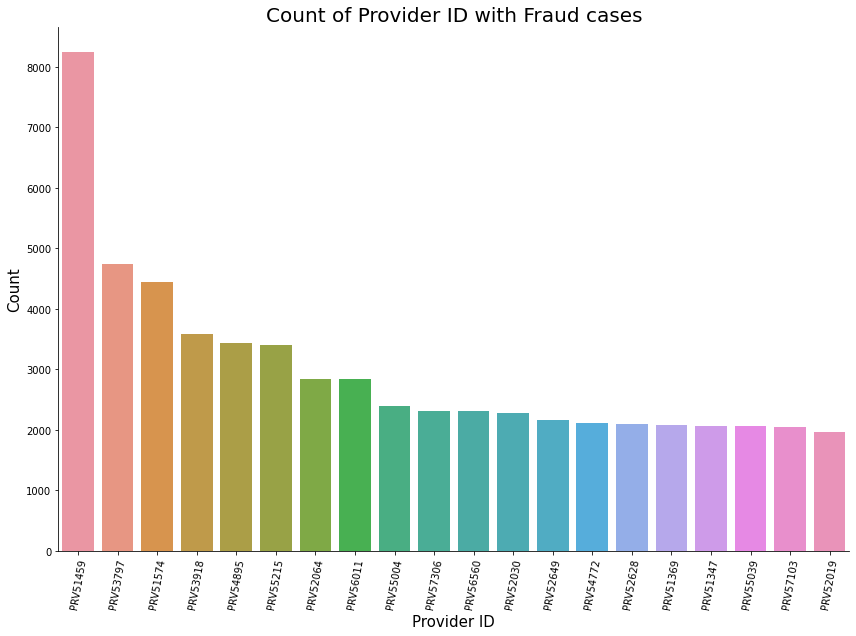

In [ ]:
df = df.head(20)

sns.catplot(x="Provider", y="PotentialFraud", data=df,kind='bar',height=8, aspect=1.5)

# plotting title and labels
plt.title('Count of Provider ID with Fraud cases',fontsize=20)
plt.ylabel('Count',size=15)
plt.xlabel('Provider ID',size=15)
plt.xticks(rotation=80)
plt.show()

Observation:
- These are the top 20 Providers with fraud cases.
- PRV51459 is the ProviderID with max no of fraud cases.
- It is quite clear ID that these people indulge in malpractice of medical sector money.

- *Now let us also look from the point of non-fraud cases same providerIDs that we used in above case.*

In [ ]:
# This the dataframe with non-fraud cases
filt = final_train['PotentialFraud']== 0

# this is the providerID for fraud cases
#fault_ID = final_train[filt][['Provider','PotentialFraud']]

In [ ]:
non_fault_ID = final_train[filt]

In [ ]:
non_fault_ID.head()

**Observation:**
- The providerID in fraud cases are not present in non-fraud case, this means that ProviderID plays important role.

###2. What is the proportion fraud cases wrt to males and female?

<Figure size 1440x432 with 0 Axes>

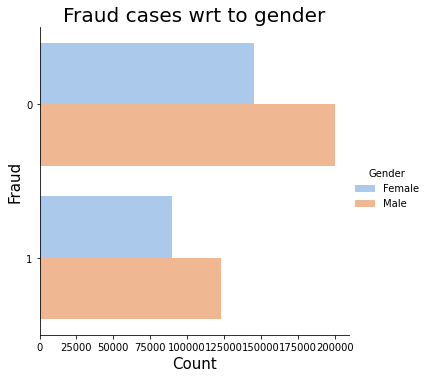

In [ ]:
# setting the size of plot
plt.figure(figsize=(20,6)) ;

sns.catplot(y="PotentialFraud", hue='Gender', kind="count",
            palette="pastel",
            data=final_train);
plt.title('Fraud cases wrt to gender',fontsize=20);
plt.xlabel('Count',size=15);
plt.ylabel('Fraud',size=15);

**Observation:**
- Most of the fraud cases are with males and also most of the non-fraud cases are with males. It clealy shows that data has more more of males.
- Female also have significant no of fraud cases.

###3. Which patients has more cases, the admitted ones or the ones who just visited the hospitals?

In [ ]:
final_train['is_inpatient'].value_counts()

0.00    517737
1.00     40474
Name: is_inpatient, dtype: int64

**NOTE** - The no admitted patients are way less than patients who just visited hopitals. So let's check for each case.

In [ ]:
# creating dataframe with only inpatient 
filt = final_train['is_inpatient']==1 

df= final_train[filt]

<Figure size 1440x432 with 0 Axes>

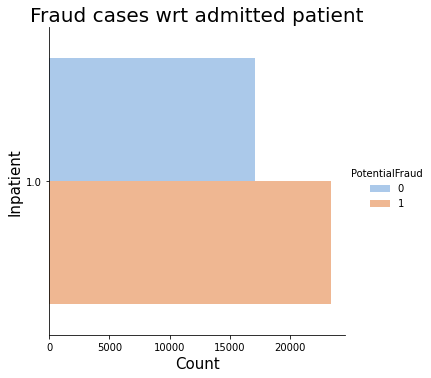

In [ ]:
plt.figure(figsize=(20,6)) ;

sns.catplot(hue="PotentialFraud", y='is_inpatient', kind="count",
            palette="pastel",
            data=df);
plt.title('Fraud cases wrt admitted patient',fontsize=20);
plt.xlabel('Count',size=15);
plt.ylabel('Inpatient',size=15);

**Observation:**
- More 50% case for inpatients are resulting in fraud.
- There fraud cases with admitted patient but their no is way to less.

In [ ]:
# creating dataframe with only inpatient 
filt = final_train['is_inpatient']== 0

df= final_train[filt]

<Figure size 1440x432 with 0 Axes>

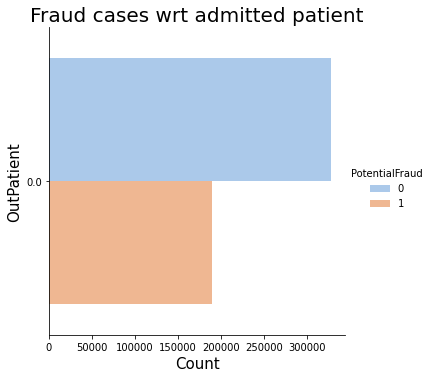

In [ ]:
plt.figure(figsize=(20,6)) ;

sns.catplot(hue="PotentialFraud", y='is_inpatient', kind="count",
            palette="pastel",
            data=df);
plt.title('Fraud cases wrt admitted patient',fontsize=20);
plt.xlabel('Count',size=15);
plt.ylabel('OutPatient',size=15);

**Observation**
- Almost 66 % times outpatient are non-fraud.
- Comparativily wrt to ratio inpatients are targerted more for fraud cases.

###4. Which race has most no of fraud cases?

<Figure size 1440x432 with 0 Axes>

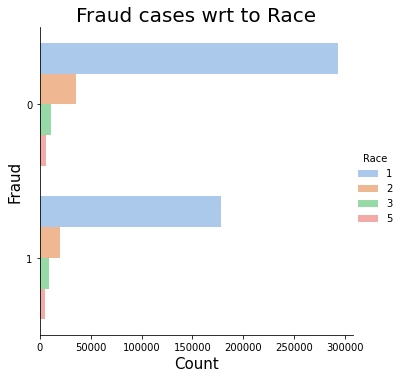

In [ ]:
plt.figure(figsize=(20,6)) ;

sns.catplot(y="PotentialFraud", hue='Race', kind="count",
            palette="pastel",
            data=final_train);
plt.title('Fraud cases wrt to Race',fontsize=20);
plt.xlabel('Count',size=15);
plt.ylabel('Fraud',size=15);

Observation:
- Race 1 is having the maximum no of count for fraud cases but if we see Race1 is also there for non-Fraud cases, the possible reason could be the data collected is having more no of Race 1 people.

###5. Is there direct relation b/w Renal Disease and Fraud cases?

<Figure size 1440x432 with 0 Axes>

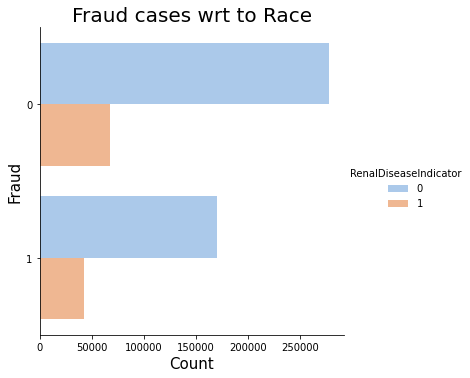

In [ ]:
plt.figure(figsize=(20,6)) ;

sns.catplot(y="PotentialFraud", hue='RenalDiseaseIndicator', kind="count",
            palette="pastel",
            data=final_train);
plt.title('Fraud cases wrt to Race',fontsize=20);
plt.xlabel('Count',size=15);
plt.ylabel('Fraud',size=15);

**Observation:**
- From the above plot it is refelected that it is not necessary to be a Fraud case with Renal Disease.


###6. What is the distribution inpatient reimburement annually for fraud and non-fraud case?

In [ ]:
filt = final_train['is_inpatient']==1

In [ ]:
df1= final_train[filt]

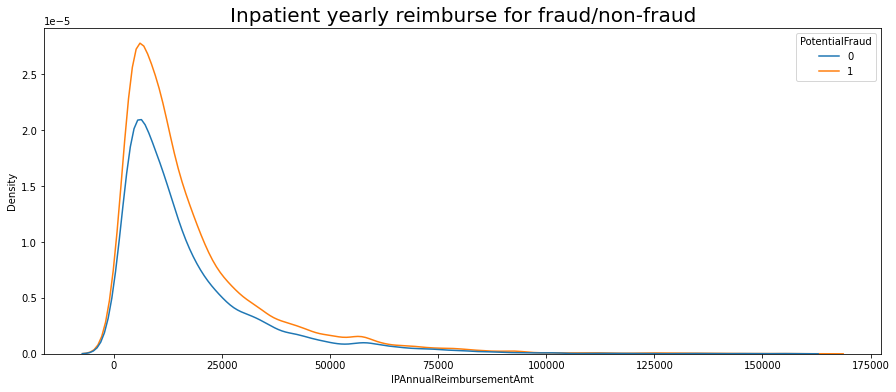

In [ ]:
# plotting distribution IPAnnualreimbursement
plt.figure(figsize=(15,6)) ;
sns.kdeplot(data=df1, x="IPAnnualReimbursementAmt",hue='PotentialFraud');
plt.title('Inpatient yearly reimburse for fraud/non-fraud',fontsize=20);


Observation:
- Reimbursement for fraud cases have amount larger than your non fraud case.

###7. What is the distribution of inpatient deductable amt annually?

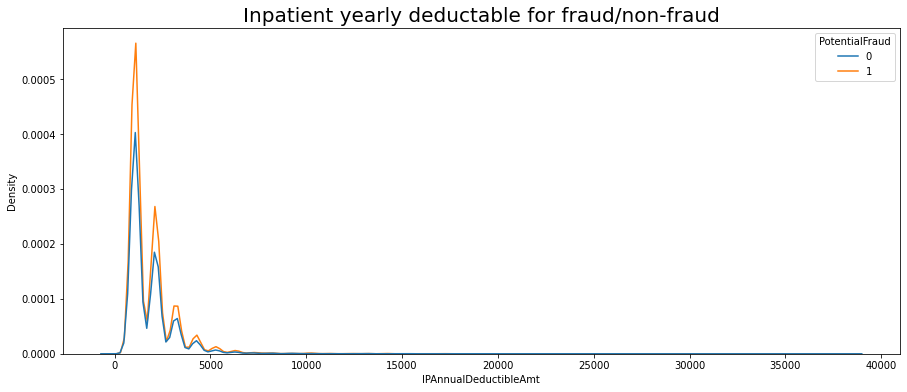

In [ ]:
# plotting distribution
plt.figure(figsize=(15,6)) ;
sns.kdeplot(data=df1, x="IPAnnualDeductibleAmt",hue='PotentialFraud');
plt.title('Inpatient yearly deductable for fraud/non-fraud',fontsize=20);


Observation:
- Deductable for fraud cases have amount larger than your non fraud case.

###8. What is the distribution of outpatient reimburement annually?

In [ ]:
filt = final_train['is_inpatient']== 0
df2 = final_train[filt]

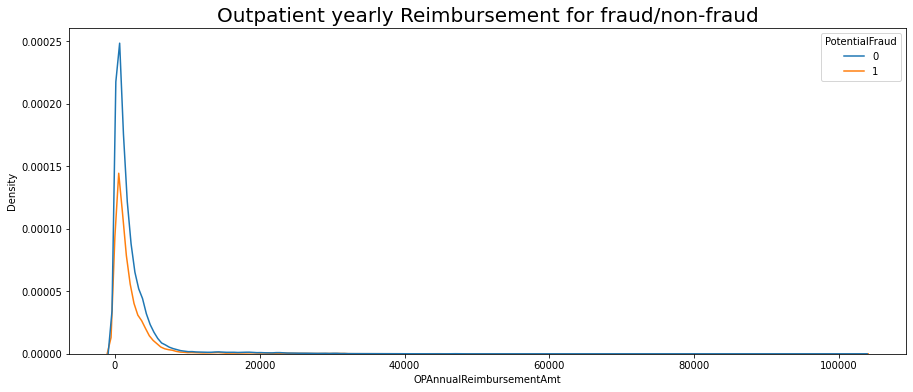

In [ ]:
# plotting distribution
plt.figure(figsize=(15,6)) ;
sns.kdeplot(data=df2, x="OPAnnualReimbursementAmt",hue='PotentialFraud');
plt.title('Outpatient yearly Reimbursement for fraud/non-fraud',fontsize=20);


Observation:
- There some outliers as the tail is flat with high values.
- The inpatient reimbursement amount is way more times the outpatient amount and the reason for this could be because of the fact amount charged for hopitalised patient is more than regular patient.

###9. What is the distribution of outpatient deductable amt annually?

In [ ]:
filt = final_train['is_inpatient']==0

df3 = final_train[filt]

Text(0.5, 1.0, 'Outpatient yearly deductable for fraud/non-fraud')

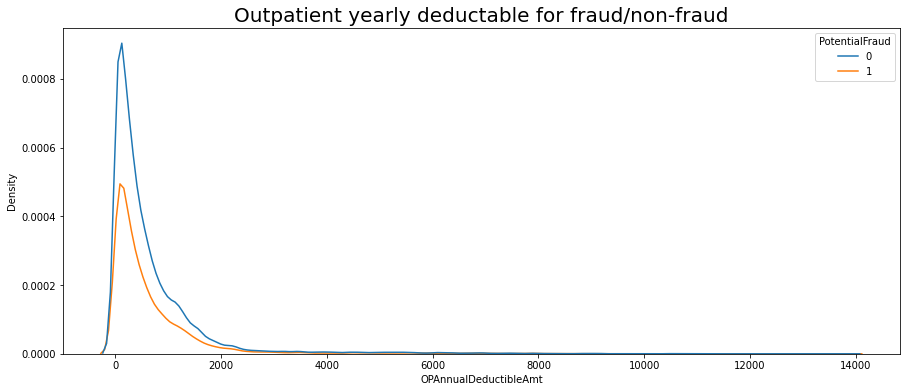

In [ ]:
plt.figure(figsize=(15,6)) ;
sns.kdeplot(data=df3, x="OPAnnualDeductibleAmt",hue='PotentialFraud');
plt.title('Outpatient yearly deductable for fraud/non-fraud',fontsize=20)

Observation:
- There some outliers as the tail is flat with high values.
- For fraud cases in OutPatient yearly deductable amount is less than non fraud.

###10. Which states are related to fraud cases?

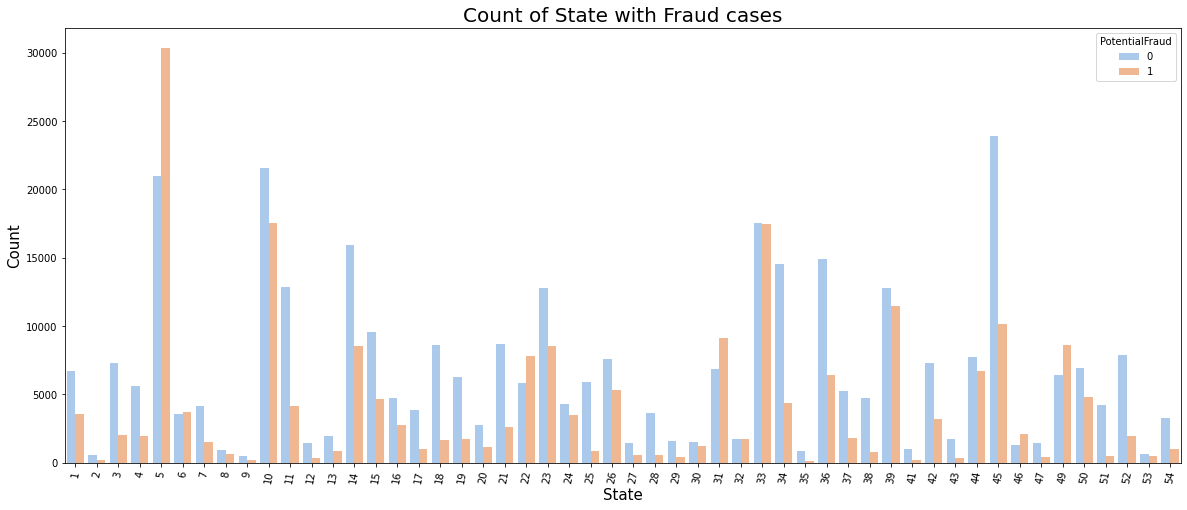

In [ ]:
# setting the size of plot
plt.figure(figsize=(20,8)) 

sns.countplot(x='State', data=final_train, hue = 'PotentialFraud',orient="h", palette="pastel")
plt.title('Count of State with Fraud cases',fontsize=20)
plt.ylabel('Count',size=15)
plt.xlabel('State',size=15)
plt.xticks(rotation=80)
plt.show()

**Observation:**
- Some of the state code like 5,10,33,39,45,etc are very high in no for fraud cases.
- The above state code has like 50% of non-fraud cases.

###11. Do dead patients are targeted for a fraud case?

<Figure size 1440x432 with 0 Axes>

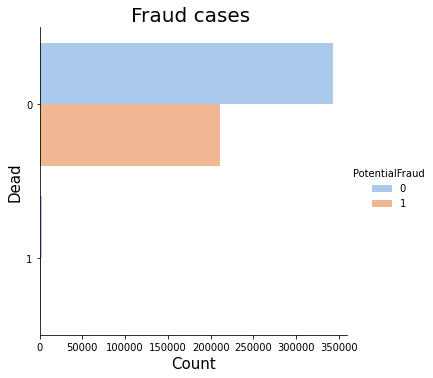

In [ ]:
plt.figure(figsize=(20,6)) ;

sns.catplot(y="is_Dead", hue='PotentialFraud', kind="count",
            palette="pastel",
            data=final_train);
plt.title('Fraud cases ',fontsize=20);
plt.xlabel('Count',size=15);
plt.ylabel('Dead',size=15);

**Observation:**
- The basic idea that we get is that if a patient is dead then there is no fraud case.
- The above observation could also be due to low no of death. So let's find out.

In [ ]:
final_train['is_Dead'].value_counts()

0    554080
1      4131
Name: is_Dead, dtype: int64

- Since the no of deaths is way less than non-deaths.So let's dig a little deeper.

In [ ]:
# creating a dataframe with dead patients only
filt = final_train['is_Dead']==1
df = final_train[filt]

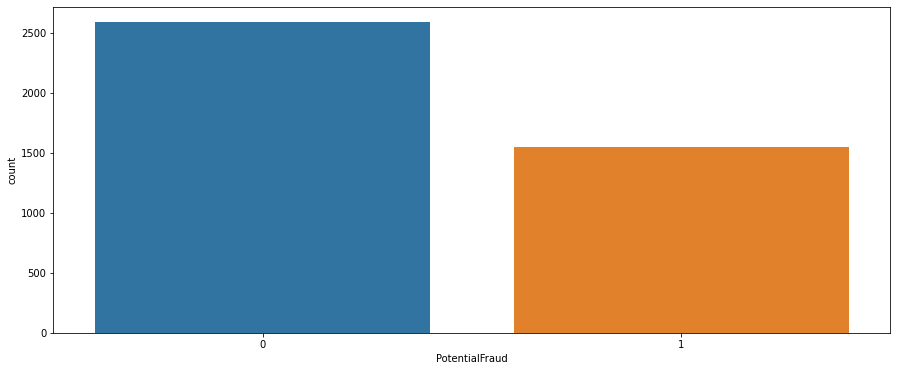

In [ ]:
plt.figure(figsize=(15,6)) ;

sns.countplot(x="PotentialFraud", data=df);

**Observation:**
- Out of the 4k dead patients more than 1500 are cases of fraud,
so we get idea that if a patient is dead there is a possibilty of the fraud.

In [ ]:
final_train.head()

,Provider,PotentialFraud,Gender,Race,RenalDiseaseIndicator,State,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,InscClaimAmtReimbursed,DeductibleAmtPaid,is_inpatient,Age,Days_Admitted,is_Dead,Hospitalization_Duration,Claim_Period,ExtraClaimDays,PerProvider_mean_InscClaimAmtReimbursed,PerProvider_mean_DeductibleAmtPaid,PerProvider_mean_IPAnnualReimbursementAmt,PerProvider_mean_IPAnnualDeductibleAmt,PerProvider_mean_OPAnnualReimbursementAmt,PerProvider_mean_OPAnnualDeductibleAmt,PerProvider_mean_Age,PerProvider_mean_NoOfMonths_PartACov,PerProvider_mean_NoOfMonths_PartBCov,PerProvider_mean_Hospitalization_Duration,PerProvider_mean_Claim_Period,PerAttendingPhysician_mean_InscClaimAmtReimbursed,PerAttendingPhysician_mean_DeductibleAmtPaid,PerAttendingPhysician_mean_IPAnnualReimbursementAmt,PerAttendingPhysician_mean_IPAnnualDeductibleAmt,PerAttendingPhysician_mean_OPAnnualReimbursementAmt,PerAttendingPhysician_mean_OPAnnualDeductibleAmt,PerAttendingPhysician_mean_Age,PerAttendingPhysician_mean_NoOfMonths_PartACov,PerAttendingPhysician_mean_NoOfMonths_PartBCov,PerAttendingPhysician_mean_Hospitalization_Duration,PerAttendingPhysician_mean_Claim_Period,PerOperatingPhysician_mean_InscClaimAmtReimbursed,PerOperatingPhysician_mean_DeductibleAmtPaid,PerOperatingPhysician_mean_IPAnnualReimbursementAmt,PerOperatingPhysician_mean_IPAnnualDeductibleAmt,PerOperatingPhysician_mean_OPAnnualReimbursementAmt,PerOperatingPhysician_mean_OPAnnualDeductibleAmt,PerOperatingPhysician_mean_Age,PerOperatingPhysician_mean_NoOfMonths_PartACov,PerOperatingPhysician_mean_NoOfMonths_PartBCov,PerOperatingPhysician_mean_Hospitalization_Duration,PerOperatingPhysician_mean_Claim_Period,PerOtherPhysician_mean_InscClaimAmtReimbursed,PerOtherPhysician_mean_DeductibleAmtPaid,PerOtherPhysician_mean_IPAnnualReimbursementAmt,PerOtherPhysician_mean_IPAnnualDeductibleAmt,PerOtherPhysician_mean_OPAnnualReimbursementAmt,PerOtherPhysician_mean_OPAnnualDeductibleAmt,PerOtherPhysician_mean_Age,PerOtherPhysician_mean_NoOfMonths_PartACov,PerOtherPhysician_mean_NoOfMonths_PartBCov,PerOtherPhysician_mean_Hospitalization_Duration,PerOtherPhysician_mean_Claim_Period
0,PRV51001,0,Female,1,1,1,12,12,1,1,1,1,0,0,1,1,0,0,0,0,0,300,110,20,0.00,0.00,79,0,0,0.00,1,0.00,4185.60,213.60,17606.00,897.12,2615.20,463.92,78.28,12.00,12.00,1.20,2.44,20.00,0.00,0.00,0.00,300.00,110.00,79.00,12.00,12.00,0.00,1.00,495.58,41.86,4555.61,514.20,2185.89,623.85,73.24,11.93,11.94,0.22,2.57,20.00,0.00,0.00,0.00,300.00,110.00,79.00,12.00,12.00,0.00,1.00
1,PRV51001,0,Female,1,0,1,12,12,1,0,0,0,0,0,1,1,1,0,1,0,0,720,10,700,0.00,0.00,66,0,0,0.00,2,0.00,4185.60,213.60,17606.00,897.12,2615.20,463.92,78.28,12.00,12.00,1.20,2.44,300.00,26.67,0.00,0.00,1703.33,286.67,64.33,12.00,12.00,0.00,1.33,495.58,41.86,4555.61,514.20,2185.89,623.85,73.24,11.93,11.94,0.22,2.57,550.00,0.00,8160.00,1068.00,7090.00,854.00,62.50,12.00,12.00,0.00,1.50
2,PRV51001,0,Male,1,0,1,12,12,0,0,1,0,0,0,1,1,0,1,0,0,0,1380,370,900,0.00,0.00,76,0,0,0.00,1,0.00,4185.60,213.60,17606.00,897.12,2615.20,463.92,78.28,12.00,12.00,1.20,2.44,647.50,0.00,0.00,0.00,1932.50,220.00,74.50,12.00,12.00,0.00,1.00,495.58,41.86,4555.61,514.20,2185.89,623.85,73.24,11.93,11.94,0.22,2.57,1235.30,106.61,5785.40,631.68,2299.65,656.33,73.41,11.94,11.95,0.66,2.92
3,PRV51001,0,Female,1,0,1,12,12,1,1,1,1,1,1,1,1,0,0,0,2020,1068,6700,2700,500,0.00,0.00,73,0,0,0.00,2,0.00,4185.60,213.60,17606.00,897.12,2615.20,463.92,78.28,12.00,12.00,1.20,2.44,500.00,0.00,2020.00,1068.00,6700.00,2700.00,73.00,12.00,12.00,0.00,2.00,500.00,0.00,2020.00,1068.00,6700.00,2700.00,73.00,12.00,12.00,0.00,2.00,1235.30,106.61,5785.40,631.68,2299.65,656.33,7

### 12. If there are extra claim days,then how does it impact a fraud case?

In [ ]:
final_train['ExtraClaimDays'].value_counts()

0.00    558194
3.00         8
1.00         5
2.00         4
Name: ExtraClaimDays, dtype: int64

In [ ]:
# creating a dataframe with extra claim days only
filt = (final_train['ExtraClaimDays']==1.00 ) | (final_train['ExtraClaimDays']== 2.00) | (final_train['ExtraClaimDays']== 3.00)
df = final_train[filt]

<Figure size 1440x432 with 0 Axes>

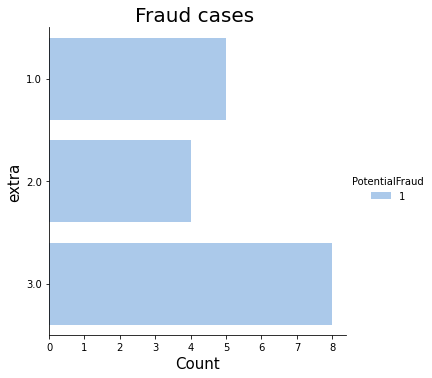

In [ ]:
plt.figure(figsize=(20,6)) ;

sns.catplot(y="ExtraClaimDays", hue='PotentialFraud', kind="count",
            palette="pastel",
            data=df);
plt.title('Fraud cases ',fontsize=20);
plt.xlabel('Count',size=15);
plt.ylabel('extra claim days',size=15);

**Observation:**
- So it is confirmed that whenever there are extra claimed days then is has to to be a fraud case.

###13. Pairplots to show combinations of which feature is important.

In [ ]:
df= final_train[ ['IPAnnualReimbursementAmt',
       'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
       'OPAnnualDeductibleAmt', 'InscClaimAmtReimbursed', 'DeductibleAmtPaid','PotentialFraud']]

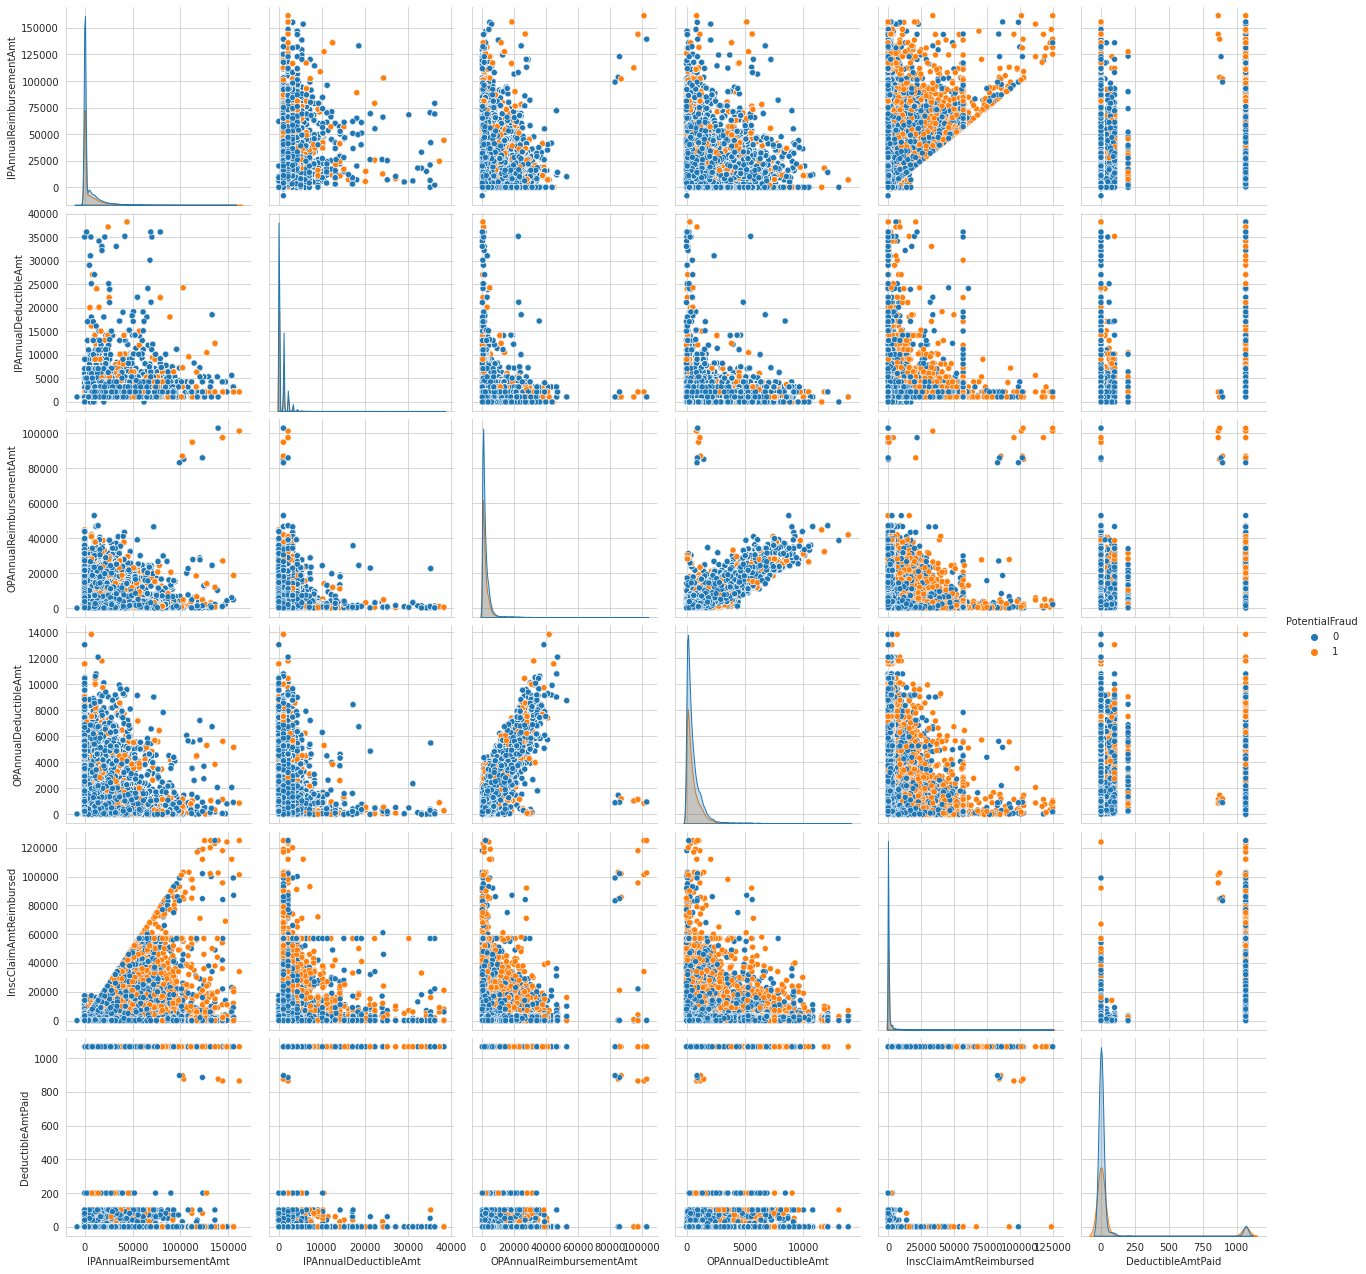

In [ ]:
sns.set_style("whitegrid");
sns.pairplot(df, hue="PotentialFraud", height=3)

**Observation:**
- Most of the pairplot are overlapping but if we see feature InsClaimAmtReimburse we are able to see both fraud and non-fraud cases.

### 14.Do you think count of disease has anything to do with fraud case?

- Adding a column count_of_disease in train and test data

In [ ]:
# train data
final_train['count_of_disease']= final_train.iloc[:, 8:19].sum(axis=1)
final_train['count_of_disease'] = final_train['count_of_disease'] + final_train['RenalDiseaseIndicator']

In [ ]:
#test data
final_test['count_of_disease']= final_test.iloc[:, 8:19].sum(axis=1)
final_test['count_of_disease'] = final_test['count_of_disease'] + final_test['RenalDiseaseIndicator']

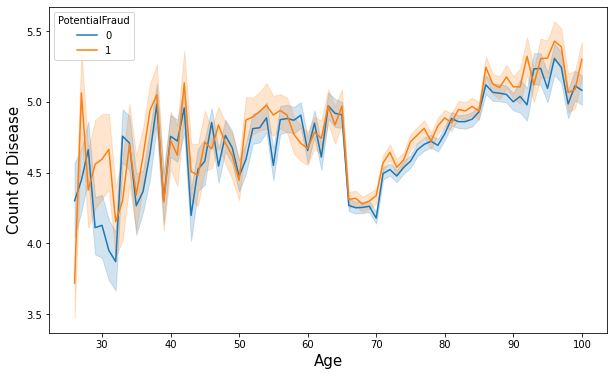

In [ ]:
plt.figure(figsize=(10,6)) ;

sns.lineplot(data=final_train, x="Age", y="count_of_disease", hue="PotentialFraud")

plt.xlabel('Age',size=15);
plt.ylabel('Count of Disease',size=15);

**Observation:**
- For most of the time if see above count of diseases are higher for fraud case at any age.
- The possible reasoning for this could be the amount charged of each disease.

### Taking a final peek at our train and test data before moving to first cut modelling.

In [ ]:
final_train.head()

,Provider,PotentialFraud,Gender,Race,RenalDiseaseIndicator,State,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,InscClaimAmtReimbursed,DeductibleAmtPaid,is_inpatient,Age,Days_Admitted,is_Dead,Hospitalization_Duration,Claim_Period,ExtraClaimDays,PerProvider_mean_InscClaimAmtReimbursed,PerProvider_mean_DeductibleAmtPaid,PerProvider_mean_IPAnnualReimbursementAmt,PerProvider_mean_IPAnnualDeductibleAmt,PerProvider_mean_OPAnnualReimbursementAmt,PerProvider_mean_OPAnnualDeductibleAmt,PerProvider_mean_Age,PerProvider_mean_NoOfMonths_PartACov,PerProvider_mean_NoOfMonths_PartBCov,PerProvider_mean_Hospitalization_Duration,PerProvider_mean_Claim_Period,PerAttendingPhysician_mean_InscClaimAmtReimbursed,PerAttendingPhysician_mean_DeductibleAmtPaid,PerAttendingPhysician_mean_IPAnnualReimbursementAmt,PerAttendingPhysician_mean_IPAnnualDeductibleAmt,PerAttendingPhysician_mean_OPAnnualReimbursementAmt,PerAttendingPhysician_mean_OPAnnualDeductibleAmt,PerAttendingPhysician_mean_Age,PerAttendingPhysician_mean_NoOfMonths_PartACov,PerAttendingPhysician_mean_NoOfMonths_PartBCov,PerAttendingPhysician_mean_Hospitalization_Duration,PerAttendingPhysician_mean_Claim_Period,PerOperatingPhysician_mean_InscClaimAmtReimbursed,PerOperatingPhysician_mean_DeductibleAmtPaid,PerOperatingPhysician_mean_IPAnnualReimbursementAmt,PerOperatingPhysician_mean_IPAnnualDeductibleAmt,PerOperatingPhysician_mean_OPAnnualReimbursementAmt,PerOperatingPhysician_mean_OPAnnualDeductibleAmt,PerOperatingPhysician_mean_Age,PerOperatingPhysician_mean_NoOfMonths_PartACov,PerOperatingPhysician_mean_NoOfMonths_PartBCov,PerOperatingPhysician_mean_Hospitalization_Duration,PerOperatingPhysician_mean_Claim_Period,PerOtherPhysician_mean_InscClaimAmtReimbursed,PerOtherPhysician_mean_DeductibleAmtPaid,PerOtherPhysician_mean_IPAnnualReimbursementAmt,PerOtherPhysician_mean_IPAnnualDeductibleAmt,PerOtherPhysician_mean_OPAnnualReimbursementAmt,PerOtherPhysician_mean_OPAnnualDeductibleAmt,PerOtherPhysician_mean_Age,PerOtherPhysician_mean_NoOfMonths_PartACov,PerOtherPhysician_mean_NoOfMonths_PartBCov,PerOtherPhysician_mean_Hospitalization_Duration,PerOtherPhysician_mean_Claim_Period,count_of_disease
0,PRV51001,0,Female,1,1,1,12,12,1,1,1,1,0,0,1,1,0,0,0,0,0,300,110,20,0.00,0.00,79,0,0,0.00,1,0.00,4185.60,213.60,17606.00,897.12,2615.20,463.92,78.28,12.00,12.00,1.20,2.44,20.00,0.00,0.00,0.00,300.00,110.00,79.00,12.00,12.00,0.00,1.00,495.58,41.86,4555.61,514.20,2185.89,623.85,73.24,11.93,11.94,0.22,2.57,20.00,0.00,0.00,0.00,300.00,110.00,79.00,12.00,12.00,0.00,1.00,7
1,PRV51001,0,Female,1,0,1,12,12,1,0,0,0,0,0,1,1,1,0,1,0,0,720,10,700,0.00,0.00,66,0,0,0.00,2,0.00,4185.60,213.60,17606.00,897.12,2615.20,463.92,78.28,12.00,12.00,1.20,2.44,300.00,26.67,0.00,0.00,1703.33,286.67,64.33,12.00,12.00,0.00,1.33,495.58,41.86,4555.61,514.20,2185.89,623.85,73.24,11.93,11.94,0.22,2.57,550.00,0.00,8160.00,1068.00,7090.00,854.00,62.50,12.00,12.00,0.00,1.50,5
2,PRV51001,0,Male,1,0,1,12,12,0,0,1,0,0,0,1,1,0,1,0,0,0,1380,370,900,0.00,0.00,76,0,0,0.00,1,0.00,4185.60,213.60,17606.00,897.12,2615.20,463.92,78.28,12.00,12.00,1.20,2.44,647.50,0.00,0.00,0.00,1932.50,220.00,74.50,12.00,12.00,0.00,1.00,495.58,41.86,4555.61,514.20,2185.89,623.85,73.24,11.93,11.94,0.22,2.57,1235.30,106.61,5785.40,631.68,2299.65,656.33,73.41,11.94,11.95,0.66,2.92,4
3,PRV51001,0,Female,1,0,1,12,12,1,1,1,1,1,1,1,1,0,0,0,2020,1068,6700,2700,500,0.00,0.00,73,0,0,0.00,2,0.00,4185.60,213.60,17606.00,897.12,2615.20,463.92,78.28,12.00,12.00,1.20,2.44,500.00,0.00,2020.00,1068.00,6700.00,2700.00,73.00,12.00,12.00,0.00,2.00,500.00,0.00,2020.00,1068.00,6700.00,2700.00,73.00,12.00,12.00,0.00,2.00,1235.30,106.61,5785.40,

In [ ]:
final_test.head()

,Provider,Gender,Race,RenalDiseaseIndicator,State,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,InscClaimAmtReimbursed,DeductibleAmtPaid,is_inpatient,Age,Days_Admitted,is_Dead,Hospitalization_Duration,Claim_Period,ExtraClaimDays,PerProvider_mean_InscClaimAmtReimbursed,PerProvider_mean_DeductibleAmtPaid,PerProvider_mean_IPAnnualReimbursementAmt,PerProvider_mean_IPAnnualDeductibleAmt,PerProvider_mean_OPAnnualReimbursementAmt,PerProvider_mean_OPAnnualDeductibleAmt,PerProvider_mean_Age,PerProvider_mean_NoOfMonths_PartACov,PerProvider_mean_NoOfMonths_PartBCov,PerProvider_mean_Hospitalization_Duration,PerProvider_mean_Claim_Period,PerAttendingPhysician_mean_InscClaimAmtReimbursed,PerAttendingPhysician_mean_DeductibleAmtPaid,PerAttendingPhysician_mean_IPAnnualReimbursementAmt,PerAttendingPhysician_mean_IPAnnualDeductibleAmt,PerAttendingPhysician_mean_OPAnnualReimbursementAmt,PerAttendingPhysician_mean_OPAnnualDeductibleAmt,PerAttendingPhysician_mean_Age,PerAttendingPhysician_mean_NoOfMonths_PartACov,PerAttendingPhysician_mean_NoOfMonths_PartBCov,PerAttendingPhysician_mean_Hospitalization_Duration,PerAttendingPhysician_mean_Claim_Period,PerOperatingPhysician_mean_InscClaimAmtReimbursed,PerOperatingPhysician_mean_DeductibleAmtPaid,PerOperatingPhysician_mean_IPAnnualReimbursementAmt,PerOperatingPhysician_mean_IPAnnualDeductibleAmt,PerOperatingPhysician_mean_OPAnnualReimbursementAmt,PerOperatingPhysician_mean_OPAnnualDeductibleAmt,PerOperatingPhysician_mean_Age,PerOperatingPhysician_mean_NoOfMonths_PartACov,PerOperatingPhysician_mean_NoOfMonths_PartBCov,PerOperatingPhysician_mean_Hospitalization_Duration,PerOperatingPhysician_mean_Claim_Period,PerOtherPhysician_mean_InscClaimAmtReimbursed,PerOtherPhysician_mean_DeductibleAmtPaid,PerOtherPhysician_mean_IPAnnualReimbursementAmt,PerOtherPhysician_mean_IPAnnualDeductibleAmt,PerOtherPhysician_mean_OPAnnualReimbursementAmt,PerOtherPhysician_mean_OPAnnualDeductibleAmt,PerOtherPhysician_mean_Age,PerOtherPhysician_mean_NoOfMonths_PartACov,PerOtherPhysician_mean_NoOfMonths_PartBCov,PerOtherPhysician_mean_Hospitalization_Duration,PerOtherPhysician_mean_Claim_Period,count_of_disease
0,PRV51002,Male,1,0,1,12,12,0,0,0,0,0,0,1,0,0,0,0,0,0,1310,590,100,0.00,0.00,75,0,0,0.00,1,0.00,269.37,1.99,5560.68,588.44,2496.23,715.18,72.10,11.81,12.00,0.00,2.05,373.33,0.00,0.00,0.00,2150.00,423.33,75.33,12.00,12.00,0.00,1.00,100.00,0.00,0.00,0.00,1310.00,590.00,75.00,12.00,12.00,0.00,1.00,100.00,0.00,0.00,0.00,1310.00,590.00,75.00,12.00,12.00,0.00,1.00,1
1,PRV51002,Male,1,0,1,0,12,0,1,1,0,1,1,1,1,0,0,0,22000,3204,1020,910,40,0.00,0.00,88,0,0,0.00,1,0.00,269.37,1.99,5560.68,588.44,2496.23,715.18,72.10,11.81,12.00,0.00,2.05,55.00,0.00,11000.00,1602.00,895.00,480.00,79.00,6.00,12.00,0.00,1.00,40.00,0.00,22000.00,3204.00,1020.00,910.00,88.00,0.00,12.00,0.00,1.00,1232.91,106.46,6429.95,703.63,2515.09,712.24,73.46,11.94,11.96,0.67,3.00,22006
2,PRV51002,Male,1,0,1,0,12,0,1,1,0,1,1,1,1,0,0,0,22000,3204,1020,910,70,0.00,0.00,88,0,0,0.00,1,0.00,269.37,1.99,5560.68,588.44,2496.23,715.18,72.10,11.81,12.00,0.00,2.05,398.33,0.00,4510.00,712.00,3723.33,1148.33,71.17,10.00,12.00,0.00,1.00,495.97,42.10,5201.07,587.51,2392.27,678.58,73.35,11.94,11.95,0.22,2.61,1232.91,106.46,6429.95,703.63,2515.09,712.24,73.46,11.94,11.96,0.67,3.00,22006
3,PRV51002,Male,1,0,1,0,12,0,1,1,0,1,1,1,1,0,0,0,22000,3204,1020,910,100,0.00,0.00,88,0,0,0.00,1,0.00,269.37,1.99,5560.68,588.44,2496.23,715.18,72.10,11.81,12.00,0.00,2.05,100.00,0.00,22000.00,3204.00,1020.00,910.00,88.00,0.00,12.00,0.00,1.00,495.97,42.10,5201.07,587.51,2392.27,678.58,73.35,11.94,11.95,0.22,2.61,1232.91,106.46,6429.95,703.63,2515.09,712

In [ ]:
# removing two unncessary colmn
final_train = final_train.drop(['NoOfMonths_PartACov','NoOfMonths_PartBCov'],axis=1)
final_test = final_test.drop(['NoOfMonths_PartACov','NoOfMonths_PartBCov'],axis=1)

In [ ]:
final_train = final_train.drop(['Gender','Race'],axis=1)
final_test = final_test.drop(['Gender','Race'],axis=1)

- Group by Provider and take sum to create feature corresponding to each provider.
- We are doing so because for each provider we will get the sum of features and the no of rows will also reduce.

In [ ]:
final_train = final_train.groupby(['Provider','PotentialFraud'],as_index=False).agg('sum')
final_test = final_test.groupby(['Provider'],as_index=False).agg('sum')

In [ ]:
# saving our files
final_train.to_csv('/content/drive/MyDrive/Colab Notebooks/Self_Case_study/train_final.csv', index=False)
final_test.to_csv('/content/drive/MyDrive/Colab Notebooks/Self_Case_study/test_final.csv', index=False)